In [2]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]
 

In [3]:
src = f"/home/andres/repos/rat-mapping-paper/reports/J_SHAP/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [54]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][:500,...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (500, 8, 16, 4, 6)
b (500, 8, 16, 4, 6)
L (500, 8, 16, 4, 6)
ℓ (500, 8, 16, 4, 6)
H (500, 8, 16, 4, 6)


In [59]:
a = params[0]

In [60]:
a.shape

(500, 8, 16, 4, 6)

In [28]:
subjects = df['participant'].unique()
subjects = sorted(encoder_dict['participant'].inverse_transform(subjects))
positions = df['compound_position'].unique()
positions = sorted(encoder_dict['compound_position'].inverse_transform(positions))
compound_charge = encoder_dict[model.features[2]].inverse_transform(sorted(df['compound_charge_params'].unique()))


In [29]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]
mono = np.array(mono)

In [30]:
mono_inds = encoder_dict[model.features[1]].transform(mono)


In [12]:
mono_inds

array([ 0,  1,  2,  3,  7, 12])

In [13]:
muscles = model.response

In [23]:
a.shape

(4000, 8, 16, 4, 6)

In [16]:
compound_charge

array(['20-0-80-25', '50-0-50-0', '50-0-50-100', '80-0-20-400'],
      dtype=object)

In [72]:
selec_a = a[:, :, mono_inds, :, :]

In [73]:
selec_a.shape

(500, 8, 6, 4, 6)

In [81]:
norm_y = []
norm_x = []

target = 2

for subject_ind, subject in enumerate(subjects):
    for m,muscle in enumerate(muscles):
    # Fix the subject index and size index
        a_temp = selec_a[:, subject_ind, :, :, m]
        mean_thres = np.nanmean(a_temp[:,:,2],axis=(0,1))
        curr_params = [
            params[:, subject_ind, mono_inds, :,m, None] for params in params
        ]

        x_temp = np.array([1.2*mean_thres])[None, None, None, None,:]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects),len(muscles),*norm_x.shape[2:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects),len(muscles),*norm_y.shape[2:])
norm_y = ma.masked_invalid(norm_y)

In [82]:
norm_y.shape

(8, 6, 6, 500, 4, 1)

In [ ]:
y_means = ma.mean(norm_y, axis=(3,5))
y_means.shape #subjects, muscles, positions, charges

(8, 6, 6, 4)

In [85]:
y_diffs = y_means[:,:, :,:,None] - y_means[:,:,:,None,:]
y_diffs.shape

(8, 6, 6, 4, 4)

In [86]:
y_diffs_means = ma.mean(y_diffs,axis=(1,2))

In [87]:
labels = ['20-0-80-25', '50-0-50-0', '50-0-50-100', '80-0-20-400']
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(y_diffs_means[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

<Axes: >

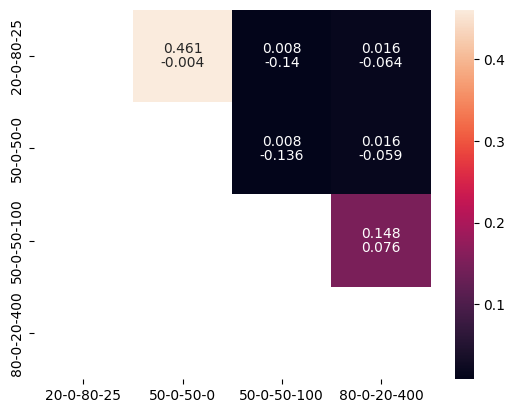

In [88]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs_means.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)